In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import (FuncFormatter, MultipleLocator)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import datetime as dt
import time

from collections import Counter
import string
import emoji

In [2]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [2]:
df = pd.read_csv('../data/df.csv', index_col=0)
df.reset_index(drop=True, inplace=True)

In [4]:
X = df['title'] + ' ' + df['selftext']
y = df['subreddit'].map({'beyondthebump':0, 'BabyBumps':1})

## Functions to extract tokens using spacy and convert that to a dataframe

In [5]:
#functions to format all the figures in consistent manner
def format_fig(fig, flag='NotTimeSeries', grid = 'NotFacetGrid'):
    if grid == 'NotFacetGrid':
        fig.suptitle(fig._suptitle.get_text(), fontsize=18, fontweight = 'extra bold', 
                     fontfamily = 'Cambria', color = 'ghostwhite')
        fig.set_facecolor('#00283b')
        axlist = fig.axes
    elif grid == 'FacetGrid':
        fig.fig.suptitle(fig.fig._suptitle.get_text(), fontsize=18, fontweight = 'extra bold', 
                     fontfamily = 'Cambria', color = 'ghostwhite')
        fig.fig.set_facecolor('#00283b')
        axlist = fig.axes.flat
    else:
        pass
    
    
    #loop through all the axes in the figure
    for ax in axlist:
        #ax = ax.get_shared_x_axes().get_siblings(ax)[1] #primary axis location
        ax.grid(False)
        ax.set_facecolor('#00283b')
        ax.tick_params(axis='both', which='both', labelsize=12, labelcolor = 'ghostwhite', color='ghostwhite')
        if flag == 'NotTimeSeries':
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
        elif flag == 'TimeSeries':
            axPrimary = ax.get_shared_x_axes().get_siblings(ax)[1]
            axPrimary.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
        elif flag =='NoFormatting':
            pass
        else:
            pass

        ax.xaxis.get_label().set_fontname('Cambria')
        ax.xaxis.get_label().set_fontsize(10)
        ax.xaxis.get_label().set_color('ghostwhite')
        ax.yaxis.get_label().set_fontname('Cambria')
        ax.yaxis.get_label().set_fontsize(10)
        ax.yaxis.get_label().set_color('ghostwhite')

        ax.spines['bottom'].set_color('ghostwhite')
        ax.spines['top'].set_color('ghostwhite') 
        ax.spines['right'].set_color('ghostwhite')
        ax.spines['left'].set_color('ghostwhite')

        ax.set_title(ax.get_title(), fontsize=14, fontweight = 'extra bold', fontfamily = 'Cambria', color = 'ghostwhite')

The code to generate dataframe from spacy tokens is adapted from 
https://towardsdatascience.com/structured-natural-language-processing-with-pandas-and-spacy-7089e66d2b10

In [5]:
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_, i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct, len(i)) for i in doc
    ]

In [6]:
def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct", "token_len"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df)

In [7]:
#converting the dataframe X to a nlp list using the pipe object as it is more memory friendly. pipe returns
#a generator
docs = list(nlp.pipe(X))


In [8]:
# converting docs to dataframe
tidy_docs = tidy_tokens(docs)

In [9]:
tidy_docs['subreddit'] = tidy_docs['doc_id'].apply(lambda x : df['subreddit'].iloc[x])

In [10]:
tidy_docs

,doc_id,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct,token_len,subreddit
0,0,Why,0,why,,WRB,advmod,ADV,True,True,False,False,3,beyondthebump
1,0,are,1,be,,VBP,ROOT,AUX,True,True,False,False,3,beyondthebump
2,0,wearable,2,wearable,,JJ,amod,ADJ,False,True,False,False,8,beyondthebump
3,0,baby,3,baby,,NN,compound,NOUN,False,True,False,False,4,beyondthebump
4,0,monitors,4,monitor,,NNS,attr,NOUN,False,True,False,False,8,beyondthebump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,10602,),127,),,-RRB-,punct,PUNCT,False,False,False,True,1,BabyBumps
128,10602,\n\n,128,\n\n,,_SP,punct,SPACE,False,False,False,False,2,BabyBumps
129,10602,Highly,129,highly,,RB,advmod,ADV,False,True,False,False,6,BabyBumps
130,10602,recommend,130,recommend,,VB,ROOT,VERB,False,True,False,False,9,BabyBumps


## **EDA using SPACY**

### Visualizing the ENTITIES for a typical reddit post
    Example Post selected here is the post with most number of found entities

In [11]:
# finding the doc_id with the most number of NERs
tidy_docs.query("ent_type != ''").groupby(['doc_id']).count().sort_values(by=['ent_type'], ascending=False).head(1)

,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct,token_len,subreddit
doc_id,,,,,,,,,,,,,
7475,214,214,214,214,214,214,214,214,214,214,214,214,214


In [12]:
doc = nlp(X.iloc[7475])
# print(doc)

In [13]:
spacy.displacy.render(doc, style="ent")
# doc_nouns = list(doc)
# print(doc_nouns)

### Distribution of posts by their unicode tokens count

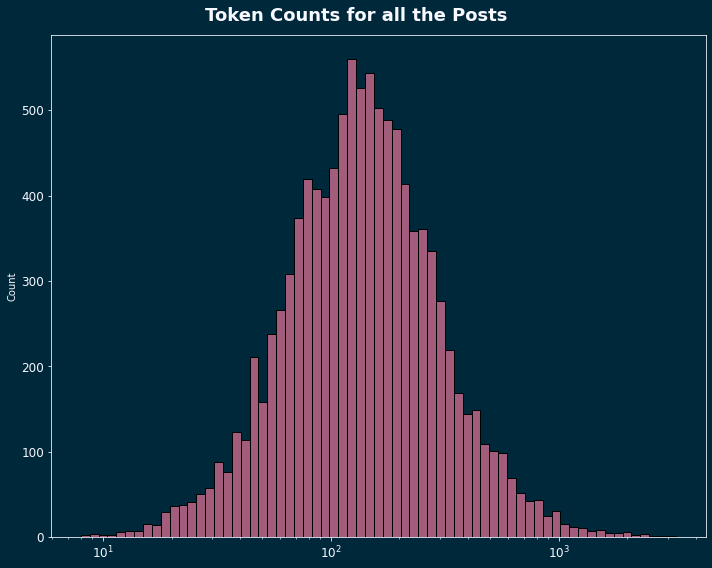

In [68]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data = tidy_docs.groupby(['doc_id', 'subreddit']).size(), log_scale = True, ax=ax, color='palevioletred')
fig.suptitle('Token Counts for all the Posts')
format_fig(fig, 'NoFormatting')
plt.tight_layout()
# plt.subplots_adjust(top=0.90, wspace = 0.30, right=0.9)

### Investigating the distribution of the word counts for the two subreddits. 
- Word counts here represent unicode tokens

In [15]:
word_count = tidy_docs.groupby(['doc_id', 'subreddit']).size()

In [16]:
word_count.name = 'count'

In [17]:
word_count = word_count.reset_index()

In [18]:
word_count

,doc_id,subreddit,count
0,0,beyondthebump,135
1,1,beyondthebump,240
2,2,beyondthebump,85
3,3,beyondthebump,235
4,4,beyondthebump,218
...,...,...,...
10598,10598,BabyBumps,113
10599,10599,BabyBumps,140
10600,10600,BabyBumps,180
10601,10601,BabyBumps,92


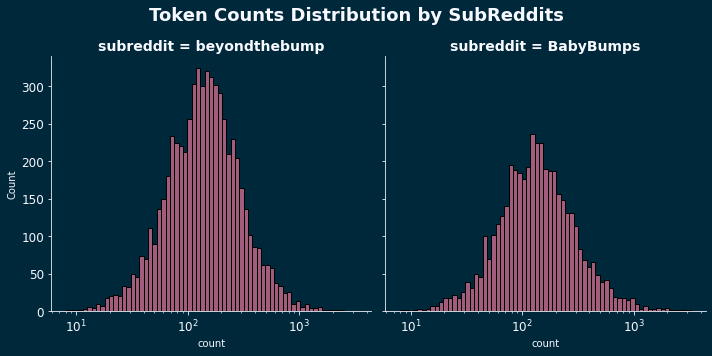

In [74]:

g = sns.displot(data=word_count, x ='count', col='subreddit', log_scale = True, 
                color='palevioletred', height = 5)
g.fig.suptitle('Token Counts Distribution by SubReddits')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()



### Investigating the distribution of the post lengths for the two subreddits. 
- Post lengths ignore punctuations, white space and stop words defined by the spacy library

In [20]:
doc_len = tidy_docs.query('is_punct == False & is_stop == False & tag != "_SP"').\
                groupby(['subreddit', 'doc_id'])['token_len'].sum()

In [21]:
doc_len.name = 'count'

In [22]:
doc_len = doc_len.reset_index().sort_values(by='subreddit', ascending=False)

In [23]:
doc_len

,subreddit,doc_id,count
5301,beyondthebump,913,267
7062,beyondthebump,2674,700
7064,beyondthebump,2676,429
7065,beyondthebump,2677,476
7066,beyondthebump,2678,133
...,...,...,...
2921,BabyBumps,9136,1118
2920,BabyBumps,9135,149
2919,BabyBumps,9134,528
2918,BabyBumps,9133,450


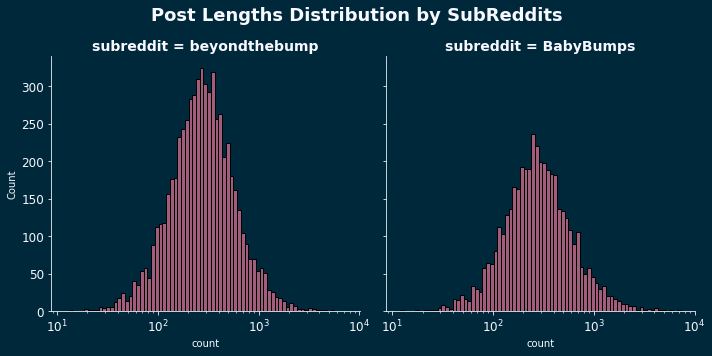

In [75]:
g = sns.displot(data=doc_len, x ='count', col='subreddit', log_scale = True, 
                color='palevioletred', height = 5)
g.fig.suptitle('Post Lengths Distribution by SubReddits')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()



### Investigating the distribution of Entities found in the two subreddits

In [76]:
# Count of all the entities found in both the subreddits
tidy_docs.query("ent_type != ''").ent_type.value_counts()

DATE           56812
TIME           16194
CARDINAL        9841
ORG             5575
ORDINAL         4833
QUANTITY        3082
PERSON          2952
GPE             1251
PERCENT         1006
MONEY            926
PRODUCT          465
WORK_OF_ART      368
NORP             306
LOC              271
FAC               86
EVENT             85
LANGUAGE          59
LAW               28
Name: ent_type, dtype: int64

In [77]:
# Splitting the count of all the entities found by the subreddits
ent_type_count = tidy_docs.query("ent_type != ''").groupby(['subreddit'])['ent_type'].value_counts()

In [78]:
ent_type_count.name = 'count'

In [79]:
ent_type_count = ent_type_count.reset_index()
ent_type_count

,subreddit,ent_type,count
0,BabyBumps,DATE,23417
1,BabyBumps,TIME,5525
2,BabyBumps,CARDINAL,4006
3,BabyBumps,ORDINAL,2628
4,BabyBumps,ORG,2488
5,BabyBumps,QUANTITY,1468
6,BabyBumps,PERSON,1264
7,BabyBumps,GPE,573
8,BabyBumps,MONEY,516
9,BabyBumps,PERCENT,442


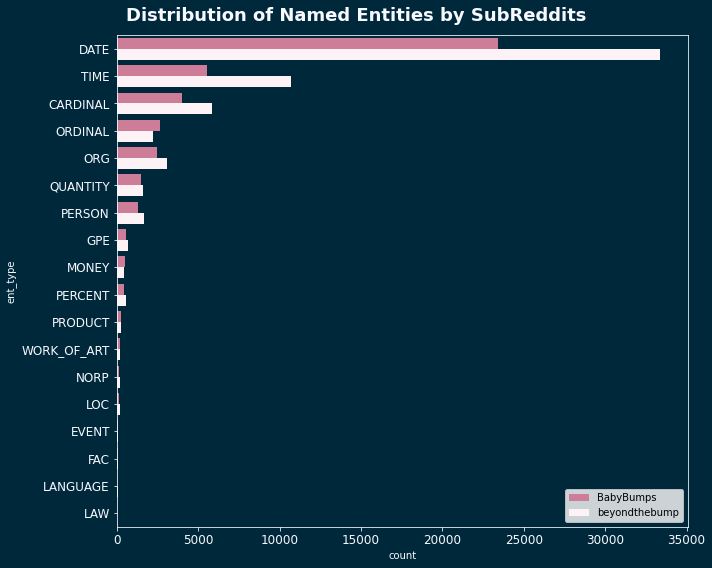

In [84]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=ent_type_count, x ='count', y='ent_type', hue='subreddit', ax=ax, orient='h',
           palette = ['palevioletred', 'lavenderblush'])
fig.suptitle('Distribution of Named Entities by SubReddits')
format_fig(fig, 'NoFormatting')
ax.legend(loc='lower right')
plt.tight_layout()
# sns.barplot(data=ent_type_count, x ='count', y='ent_type', hue='subreddit', ax=ax, orient='h');

### Investigating the commongly (top 25) occuring words in the subreddits

In [85]:
word_frequency = tidy_docs.query('is_punct == False & is_stop == False & tag != "_SP"').\
                groupby(['subreddit'])['lemma'].value_counts(). \
                groupby(level=0, group_keys=False).head(25)

In [86]:
word_frequency.name = 'count'

In [87]:
word_frequency = word_frequency.reset_index()

In [88]:
word_frequency = word_frequency.sort_values(by=['subreddit'], ascending=False)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


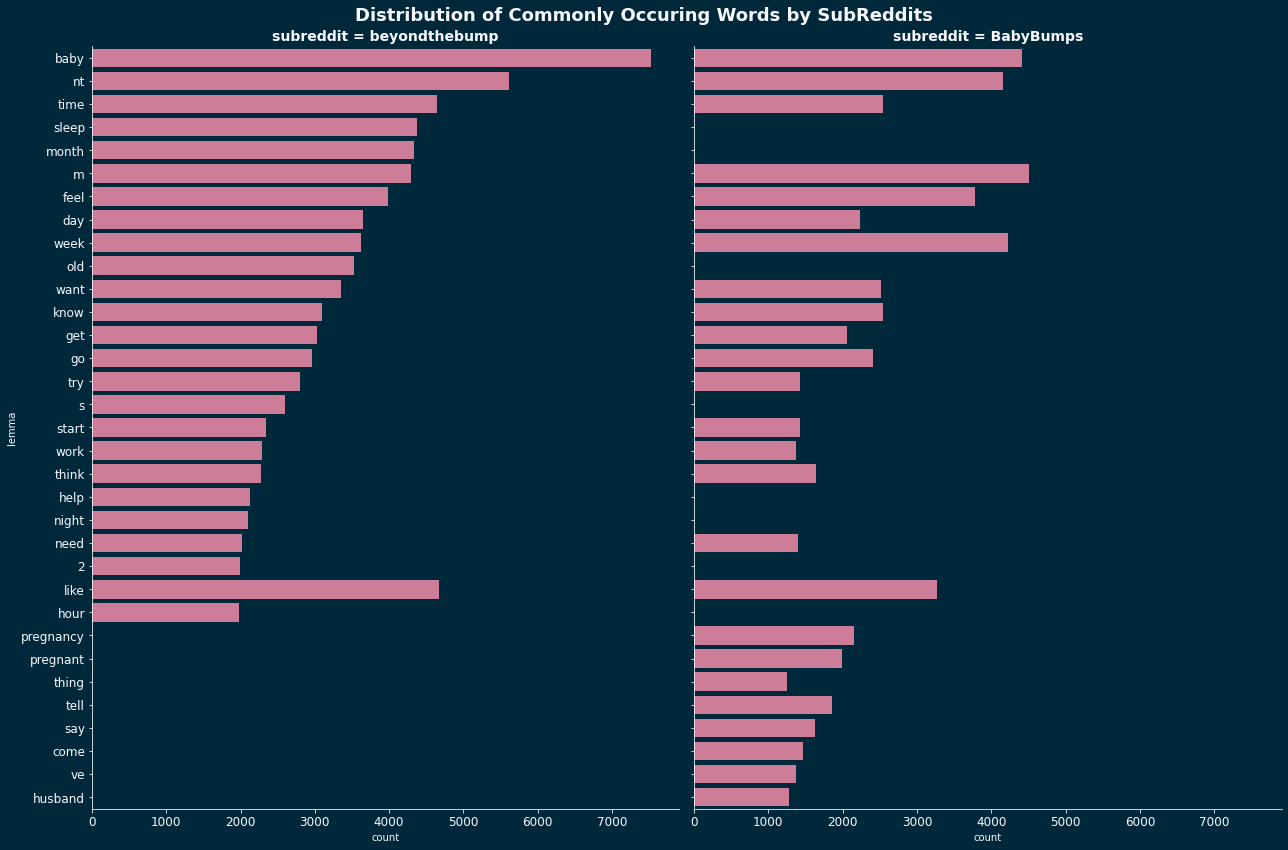

In [98]:
g = sns.catplot(data=word_frequency, x ='count', y='lemma', 
            col='subreddit', ax=ax, kind='bar', orient='h',
           color='palevioletred', height=12, aspect=0.75);
g.fig.suptitle('Distribution of Commonly Occuring Words by SubReddits')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()



### Investigating the 'tags'

In [99]:
# https://github.com/explosion/spaCy/blob/master/spacy/glossary.py
# all the tags found in the posts
tidy_docs['tag'].value_counts()

NN       236894
PRP      182284
IN       174593
RB       150110
DT       123167
JJ       113102
.        108291
VB        93965
CC        80459
VBP       77002
NNS       69503
VBD       62203
VBZ       56290
VBG       54496
PRP$      54097
,         47967
TO        38197
CD        34526
VBN       30806
_SP       26148
NNP       25954
MD        25609
RP        15726
WRB       14337
WP         7917
-RRB-      7761
-LRB-      7748
UH         6969
WDT        6693
JJR        5868
:          5259
SYM        4566
HYPH       3487
NFP        3008
JJS        2970
RBR        2890
EX         2314
PDT        2189
``         1867
''         1750
POS        1274
FW         1161
RBS         596
$           571
NNPS        513
XX          203
LS          175
ADD          61
WP$          48
AFX           8
Name: tag, dtype: int64

In [100]:
# tokens associated with each tag found
tidy_docs.groupby(['tag'])['token'].value_counts()

tag  token                                                                                                                                     
$    $                                                                                                                                              343
     #                                                                                                                                              222
     US$                                                                                                                                              2
     ft                                                                                                                                               2
     approx                                                                                                                                           1
                                                                                                

### Investigating the NN tag which corresponds to Noun forms

In [102]:
# Checking for word preceding and succeeding the NN tag token
(tidy_docs
 .groupby("doc_id")
 .apply(lambda x: x.assign(
     prev_token = lambda x: x.token.shift(1), 
     next_token = lambda x: x.token.shift(-1))
       )
 .reset_index(drop=True)
 .query("tag == 'NN'")
 .loc[:, ["doc_id", "prev_token", "token", "next_token", "subreddit"]]
)

,doc_id,prev_token,token,next_token,subreddit
3,0,wearable,baby,monitors,beyondthebump
13,0,a,notification,about,beyondthebump
16,0,a,drop,in,beyondthebump
22,0,the,difference,between,beyondthebump
24,0,between,life,and,beyondthebump
...,...,...,...,...,...
1973551,10602,4,inch,foam,BabyBumps
1973552,10602,inch,foam,mattress,BabyBumps
1973553,10602,foam,mattress,toppers,BabyBumps
1973562,10602,last,night,...,BabyBumps


In [288]:
pd.set_option('display.max_rows', 1238)

### Investigating the POS tag which correspond to possessive to understand ownership within corpus

In [106]:
tidy_docs_pos = (tidy_docs
 .groupby("doc_id")
 .apply(lambda x: x.assign(
     prev_token = lambda x: x.token.shift(1), 
     next_token = lambda x: x.token.shift(-1))
       )
 .reset_index(drop=True)
 .query("tag == 'POS'")
 .loc[:, ["doc_id", "prev_token", "token", "next_token", "subreddit"]]
)

In [107]:
tidy_docs_pos

,doc_id,prev_token,token,next_token,subreddit
606,3,children,'s,benedryl,beyondthebump
692,3,people,'s,thoughts,beyondthebump
5572,34,toddler,'s,nose,beyondthebump
5610,34,baby,'s,nose,beyondthebump
10004,56,stranger,'s,What,beyondthebump
...,...,...,...,...,...
1960661,10534,partner,'s,mom,BabyBumps
1961549,10539,people,'s,thoughts,BabyBumps
1963306,10549,husband,'s,best,BabyBumps
1963452,10549,mom,'s,side,BabyBumps


In [111]:
tidy_docs_pos['counter'] =1

In [112]:
tidy_docs_pos.groupby(['subreddit'])['prev_token'].value_counts(). \
                groupby(level=0, group_keys=False).head(10)

subreddit      prev_token
BabyBumps      baby          103
               husband        32
               people         17
               doctor         14
               mom            14
               OB             12
               daughter       10
               Baby            9
               wife            9
               everyone        8
beyondthebump  baby          120
               husband        42
               son            38
               else           29
               daughter       28
               mom            27
               LO             23
               people         19
               doctor         18
               child          15
Name: prev_token, dtype: int64

In [123]:
tidy_docs_pos.groupby(['subreddit', 'prev_token', 'next_token'])['counter'].sum().sort_values(ascending=False). \
                groupby(level=0, group_keys=False).head(20).reset_index().sort_values(by='subreddit')

,subreddit,prev_token,next_token,counter
0,BabyBumps,baby,head,14
37,BabyBumps,baby,birth,2
36,BabyBumps,children,hospital,3
35,BabyBumps,Arm,Reach,3
34,BabyBumps,Baby,head,3
33,BabyBumps,OB,nurse,3
30,BabyBumps,Mama,!,3
28,BabyBumps,baby,heartbeat,3
26,BabyBumps,husband,family,3
21,BabyBumps,baby,life,4


In [ ]:
pd.reset_option('display.max_rows')

### Investigating the entities and their distribution in the subreddits

Functions to extract entities as identified by spacy. Earlier entities were identified after splitting the doc into tokens. The following entities are identified in the entire doc without splitting them into tokens

In [125]:
def extract_ent(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.label_) for i in doc.ents
    ]

In [126]:
def tidy_ent_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "ent_type"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_ent(doc)
        meta = pd.DataFrame(meta)
        if len(meta)>0:
            meta.columns = cols[1:]
            meta = meta.assign(doc_id = ix).loc[:, cols]
            meta_df.append(meta)
        
    return pd.concat(meta_df)

DataFrame of just the entities identified

In [127]:
tidy_ent_docs = tidy_ent_tokens(docs)

In [128]:
tidy_ent_docs['subreddit'] = tidy_ent_docs['doc_id'].apply(lambda x : df['subreddit'].iloc[x])

In [129]:
tidy_ent_docs

,doc_id,token,ent_type,subreddit
0,0,Owlet,PRODUCT,beyondthebump
0,1,2f,CARDINAL,beyondthebump
1,1,2 year old,DATE,beyondthebump
2,1,4 year old,DATE,beyondthebump
3,1,a year and a half,DATE,beyondthebump
...,...,...,...,...
6,10602,one,CARDINAL,BabyBumps
7,10602,4 inch,QUANTITY,BabyBumps
8,10602,Amazon,ORG,BabyBumps
9,10602,last night,TIME,BabyBumps


Dataframe of count of each entities

In [130]:
ent_type_count = tidy_ent_docs.query("ent_type != ''").groupby(['subreddit'])['ent_type'].value_counts()

In [131]:
ent_type_count.name = 'count'

In [132]:
ent_type_count = ent_type_count.reset_index()
ent_type_count

,subreddit,ent_type,count
0,BabyBumps,DATE,10324
1,BabyBumps,CARDINAL,3332
2,BabyBumps,ORDINAL,2628
3,BabyBumps,TIME,2320
4,BabyBumps,ORG,1845
5,BabyBumps,PERSON,885
6,BabyBumps,QUANTITY,603
7,BabyBumps,GPE,542
8,BabyBumps,MONEY,292
9,BabyBumps,PERCENT,204


Distribution of each entities by subreddits

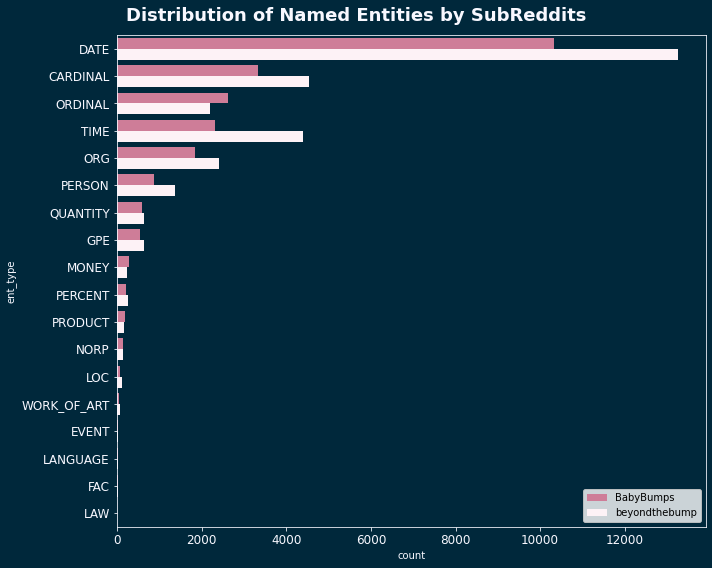

In [133]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=ent_type_count, x ='count', y='ent_type', hue='subreddit', ax=ax, orient='h',
           palette = ['palevioletred', 'lavenderblush'])
fig.suptitle('Distribution of Named Entities by SubReddits')
format_fig(fig, 'NoFormatting')
ax.legend(loc='lower right')
plt.tight_layout()
# sns.barplot(data=ent_type_count, x ='ent_type', y='count', hue='subreddit', ax=ax)

In [244]:
tidy_ent_docs.query("ent_type != ''").ent_type.value_counts()

DATE           22669
CARDINAL        7731
TIME            7040
ORDINAL         4886
ORG             4340
PERSON          2428
QUANTITY        1190
GPE             1106
PERCENT          540
MONEY            445
NORP             360
PRODUCT          315
LOC              179
WORK_OF_ART      166
FAC               63
LANGUAGE          61
EVENT             43
LAW                9
Name: ent_type, dtype: int64

In [246]:
tidy_ent_docs[tidy_ent_docs['ent_type']=='GPE']['token'].value_counts().head(25)

US                   153
UK                    63
Covid                 60
Canada                58
GP                    36
USA                   26
Australia             26
Ill                   24
Texas                 17
Germany               17
turkey                15
Florida               13
U.S.                  10
California            10
America               10
Zofran                 8
Chicco                 8
Natera                 8
RV                     7
Hawaii                 7
Mexico                 7
LA                     7
Minnesota              6
the United States      6
Kaiser                 6
Name: token, dtype: int64

In [248]:
tidy_ent_docs[tidy_ent_docs['ent_type']=='DATE']['token'].value_counts().head(25)

today          1052
yesterday       397
tomorrow        289
Today           284
the day         262
next week       182
2 weeks         175
a week          168
6 weeks         168
this week       167
last week       161
6 months        151
a few days      143
3 months        128
Monday          128
Yesterday       113
daily           112
8 weeks         112
12 weeks        111
a few weeks     109
4 months        108
Friday          104
5 weeks         102
two weeks       100
3 weeks         100
Name: token, dtype: int64

### Investigating the distribution of various entities by subreddits

Function to plot the distribution of various entities by subreddits

In [165]:
def ent_catplot(df, ent_var):
    df = df.query("ent_type == @ent_var").groupby(['subreddit'])['token'].value_counts(). \
                groupby(level=0, group_keys=False).head(25)
    df.name = 'count'
    df = df.reset_index()
    g = sns.catplot(data=df, x ='count', y='token', 
            col='subreddit', ax=ax, kind='bar', orient='h',
           color='palevioletred', height=12, aspect=0.75)
    return g

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


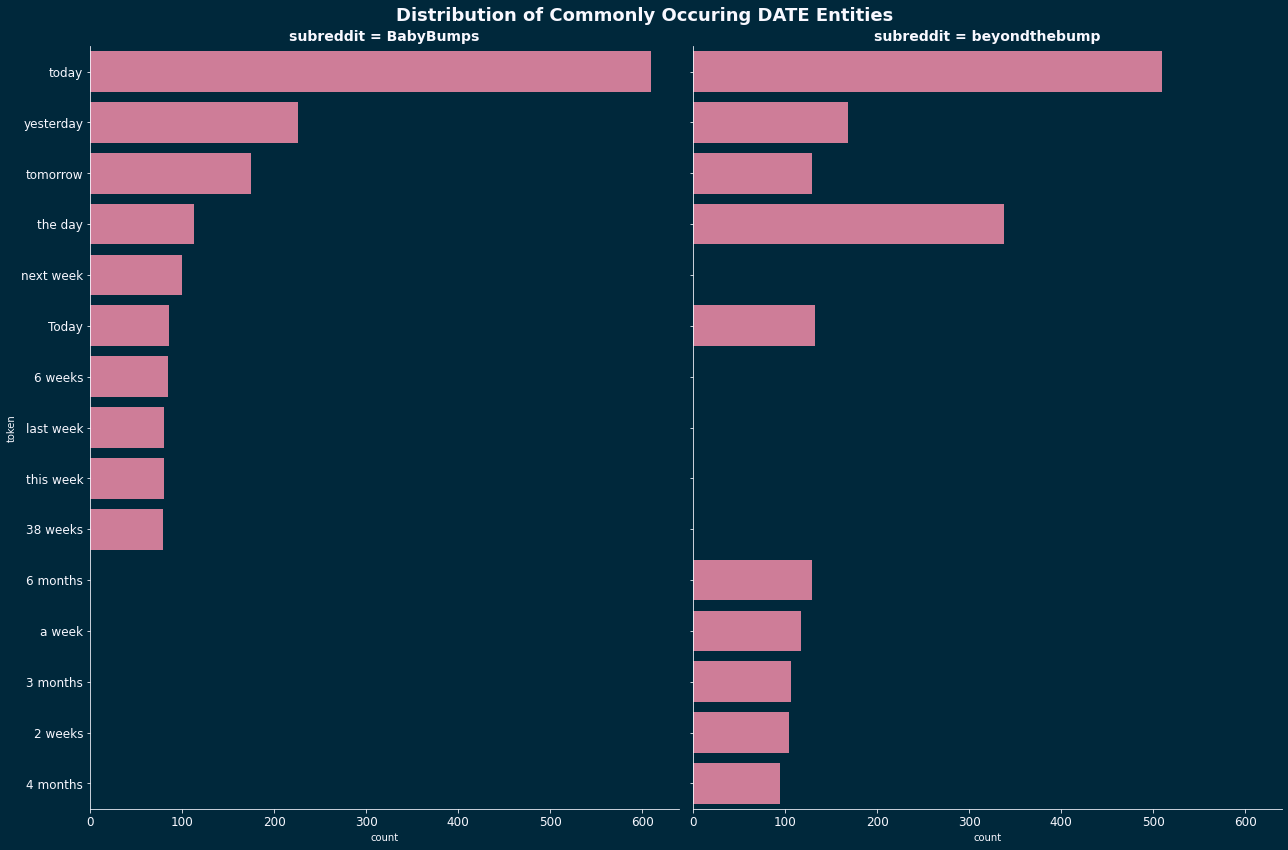

In [157]:
g = ent_catplot(tidy_ent_docs, 'DATE')
g.fig.suptitle('Distribution of Commonly Occuring DATE Entities')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()


/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


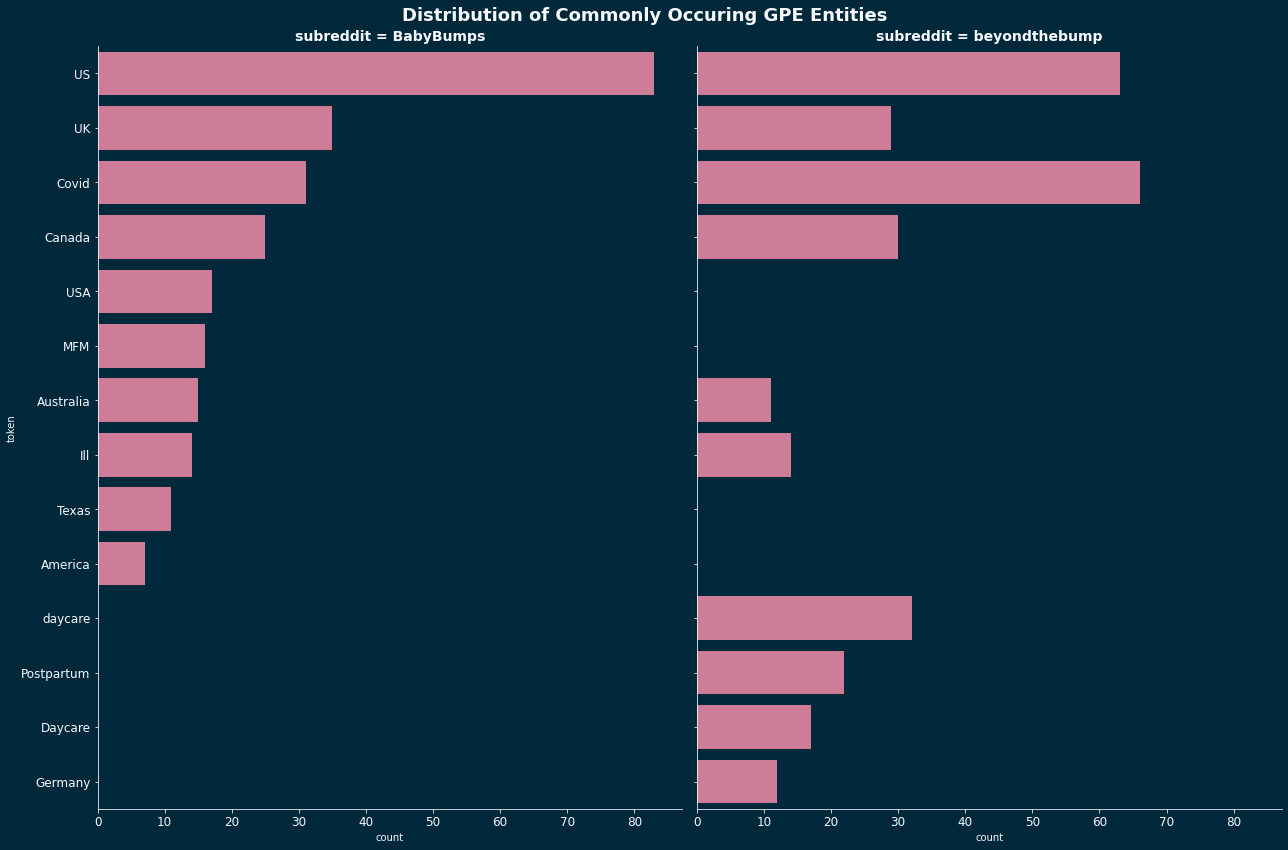

In [158]:
g = ent_catplot(tidy_ent_docs, 'GPE')
g.fig.suptitle('Distribution of Commonly Occuring GPE Entities')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


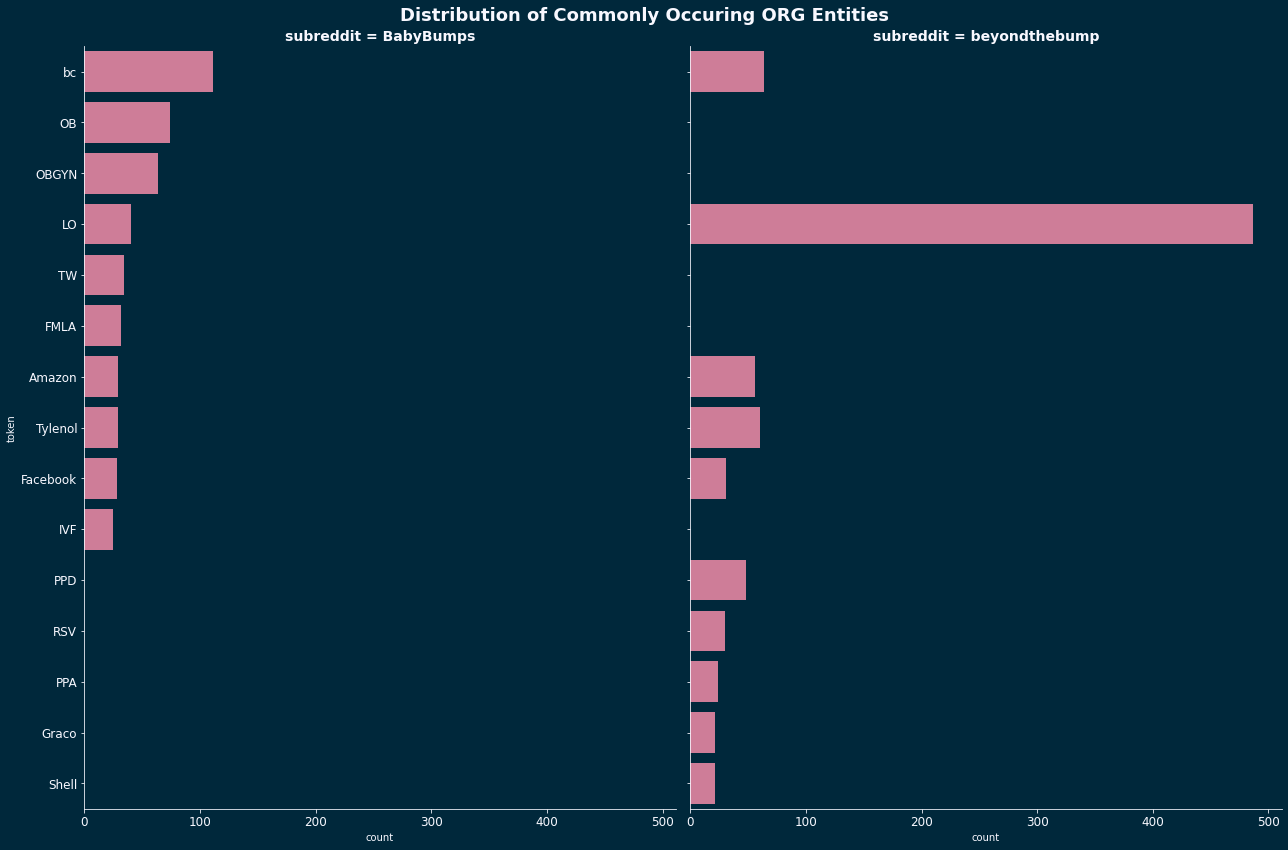

In [159]:
g = ent_catplot(tidy_ent_docs, 'ORG')
g.fig.suptitle('Distribution of Commonly Occuring ORG Entities')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


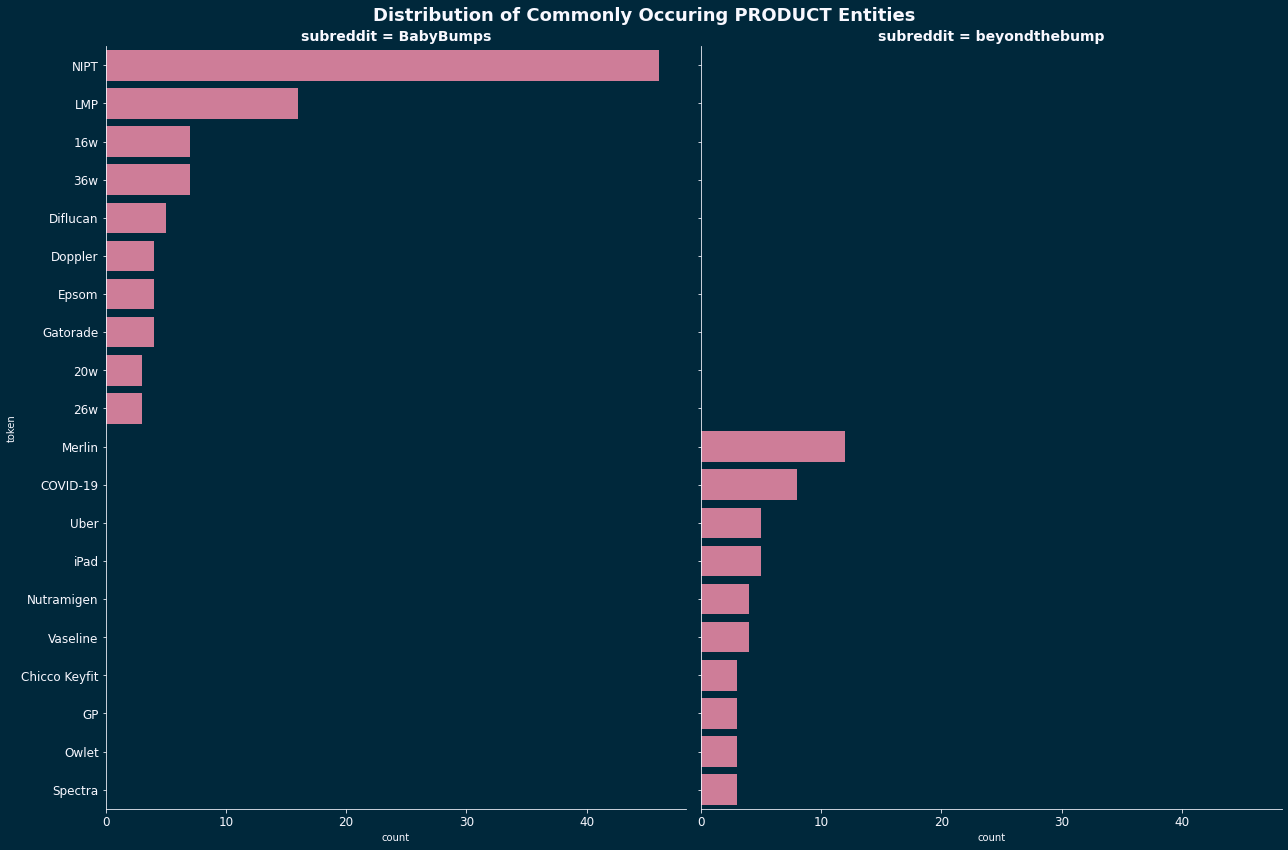

In [160]:
g = ent_catplot(tidy_ent_docs, 'PRODUCT')
g.fig.suptitle('Distribution of Commonly Occuring PRODUCT Entities')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


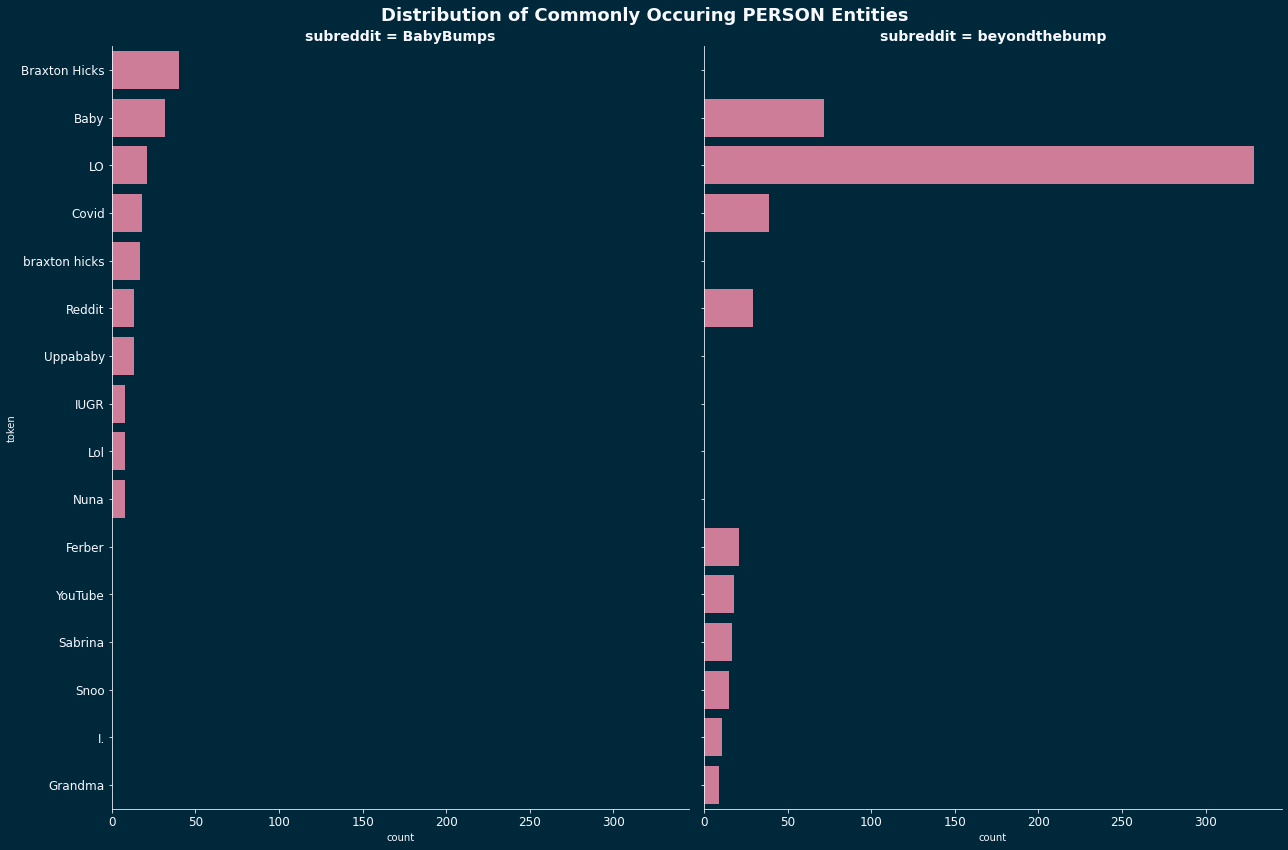

In [161]:
g = ent_catplot(tidy_ent_docs, 'PERSON')
g.fig.suptitle('Distribution of Commonly Occuring PERSON Entities')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()

In [162]:
tidy_ent_docs.query("ent_type != ''").ent_type.value_counts()

DATE           23571
CARDINAL        7869
TIME            6710
ORDINAL         4833
ORG             4264
PERSON          2248
QUANTITY        1245
GPE             1170
MONEY            528
PERCENT          454
PRODUCT          366
NORP             299
LOC              183
WORK_OF_ART      130
LANGUAGE          59
EVENT             53
FAC               38
LAW               10
Name: ent_type, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


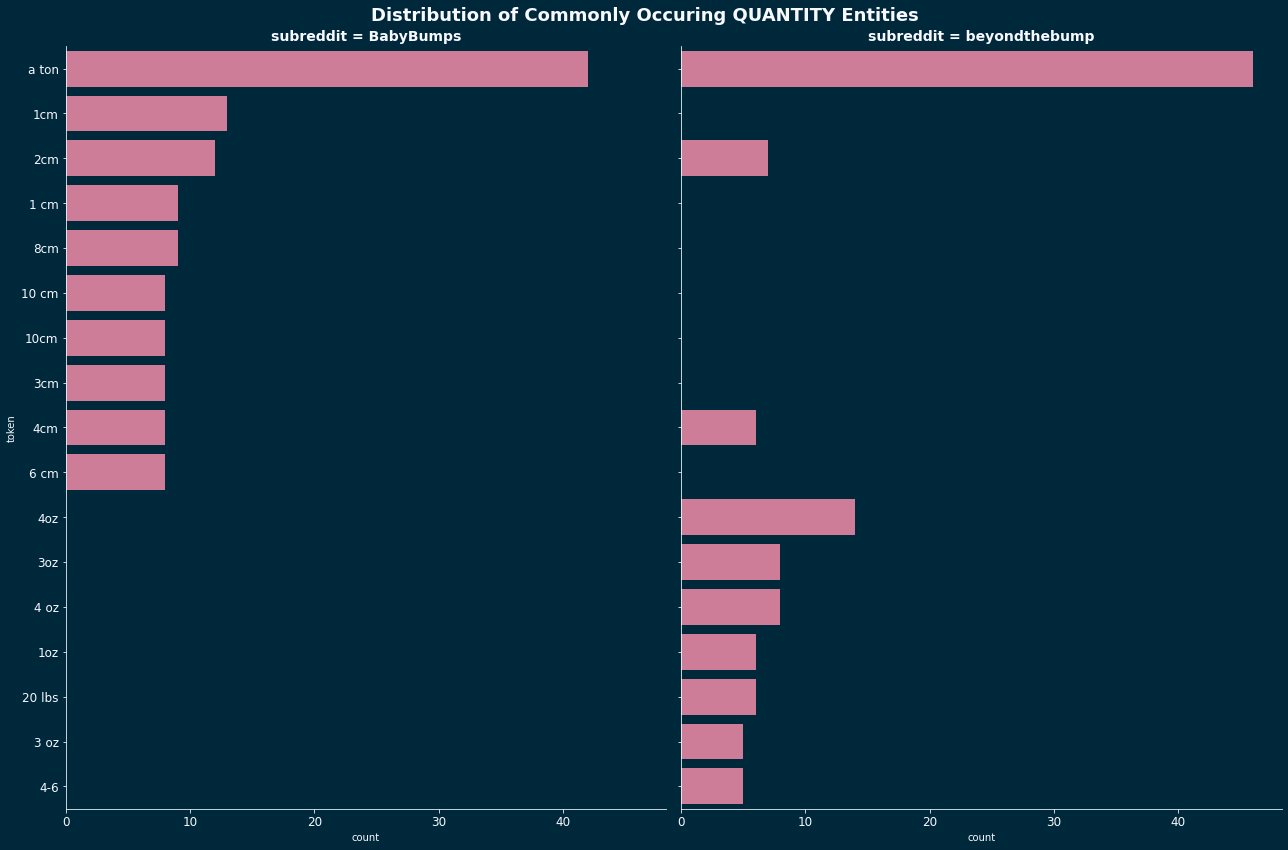

In [163]:
g = ent_catplot(tidy_ent_docs, 'QUANTITY')
g.fig.suptitle('Distribution of Commonly Occuring QUANTITY Entities')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


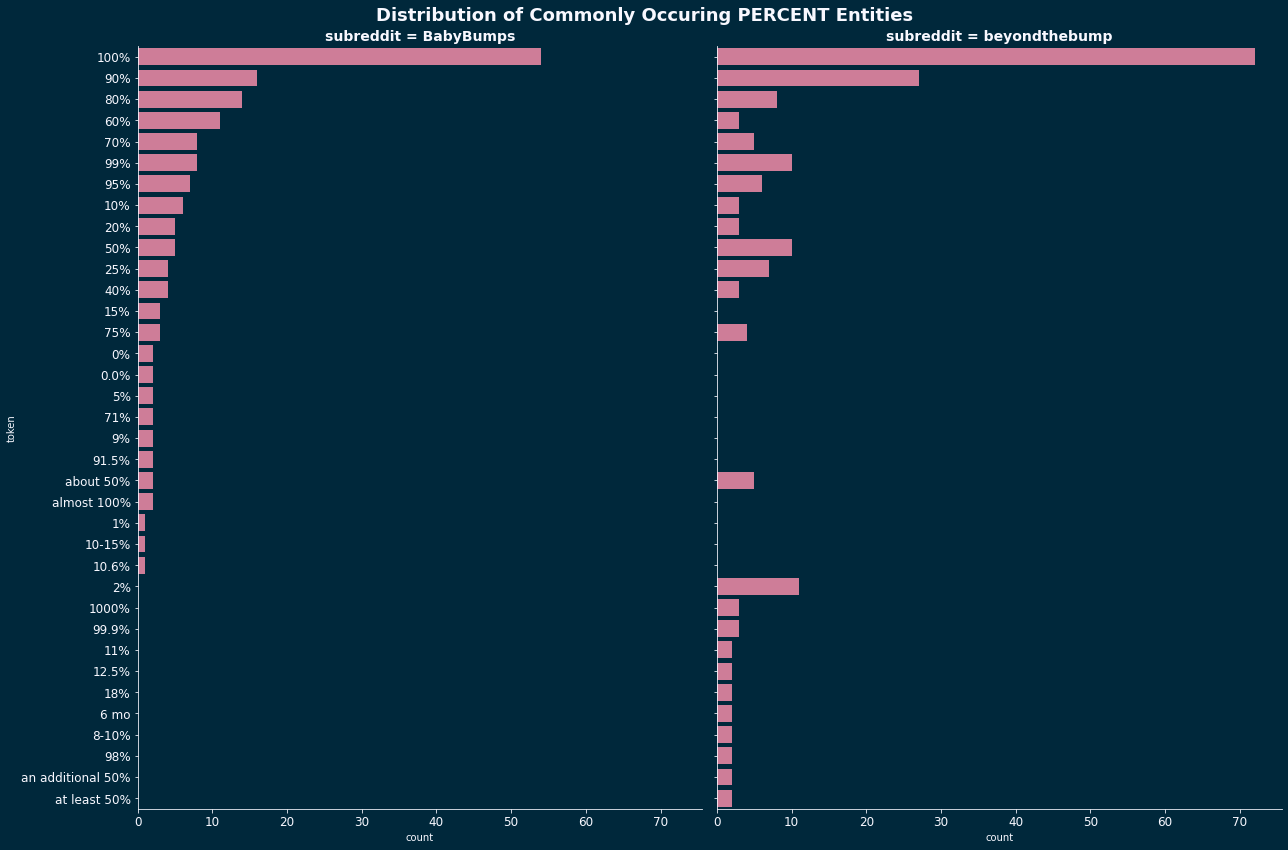

In [166]:
g = ent_catplot(tidy_ent_docs, 'PERCENT')
g.fig.suptitle('Distribution of Commonly Occuring PERCENT Entities')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


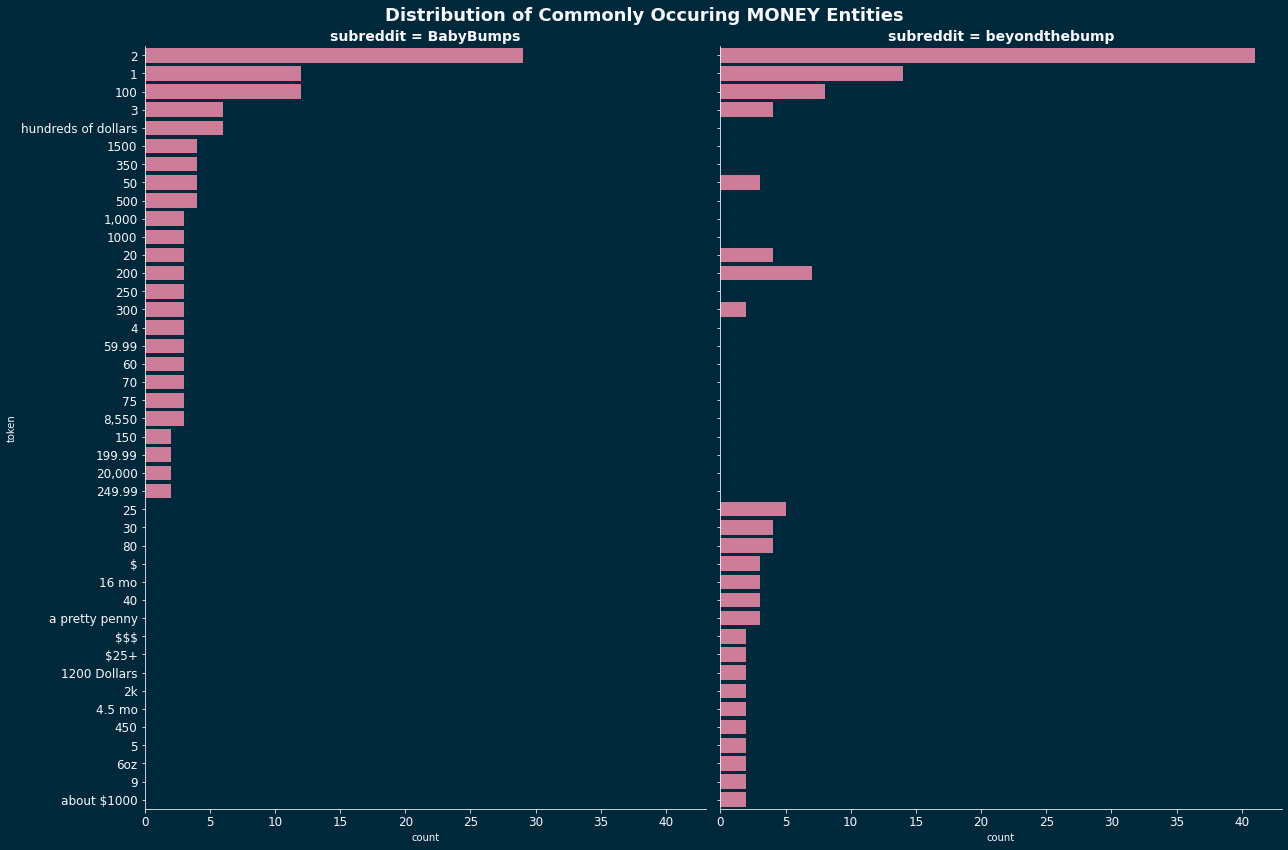

In [167]:
g = ent_catplot(tidy_ent_docs, 'MONEY')
g.fig.suptitle('Distribution of Commonly Occuring MONEY Entities')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()

### Investigating the NOUN entities to see who the author is talking about

In [168]:
def extract_noun(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text) for i in doc.noun_chunks
    ]

In [169]:
def tidy_noun_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_noun(doc)
        meta = pd.DataFrame(meta)
        if len(meta)>0:
            meta.columns = cols[1:]
            meta = meta.assign(doc_id = ix).loc[:, cols]
            meta_df.append(meta)
    return pd.concat(meta_df)

In [170]:
tidy_noun_docs = tidy_noun_tokens(docs)

In [171]:
tidy_noun_docs['subreddit'] = tidy_noun_docs['doc_id'].apply(lambda x : df['subreddit'].iloc[x])

In [172]:
tidy_noun_docs

,doc_id,token,subreddit
0,0,wearable baby monitors,beyondthebump
1,0,the Owlet,beyondthebump
2,0,a drop,beyondthebump
3,0,vitals,beyondthebump
4,0,the difference,beyondthebump
...,...,...,...
19,10602,Amazon,BabyBumps
20,10602,it,BabyBumps
21,10602,It,BabyBumps
22,10602,I,BabyBumps


In [173]:
# pd.set_option('display.max_rows', 90317)
tidy_noun_docs['token'].value_counts()

I                                               80043
it                                              18681
me                                              11064
he                                               9067
she                                              8670
                                                ...  
normal First time mom                               1
pillow cleaning                                     1
really pretty nursery rooms                         1
the NextFit Max Zip Air Convertible Car Seat        1
the chestiness                                      1
Name: token, Length: 89711, dtype: int64

In [174]:
tidy_noun_docs['counter'] = 1

In [175]:
noun_frequency = tidy_noun_docs.groupby(['subreddit'])['token'].value_counts(). \
                groupby(level=0, group_keys=False).head(25)

In [176]:
noun_frequency.name = 'count'

In [177]:
noun_frequency = noun_frequency.reset_index()

In [178]:
noun_frequency

,subreddit,token,count
0,BabyBumps,I,37061
1,BabyBumps,it,7802
2,BabyBumps,me,5391
3,BabyBumps,you,3328
4,BabyBumps,we,2741
5,BabyBumps,they,2495
6,BabyBumps,she,2337
7,BabyBumps,he,2108
8,BabyBumps,what,1584
9,BabyBumps,anyone,1350


/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


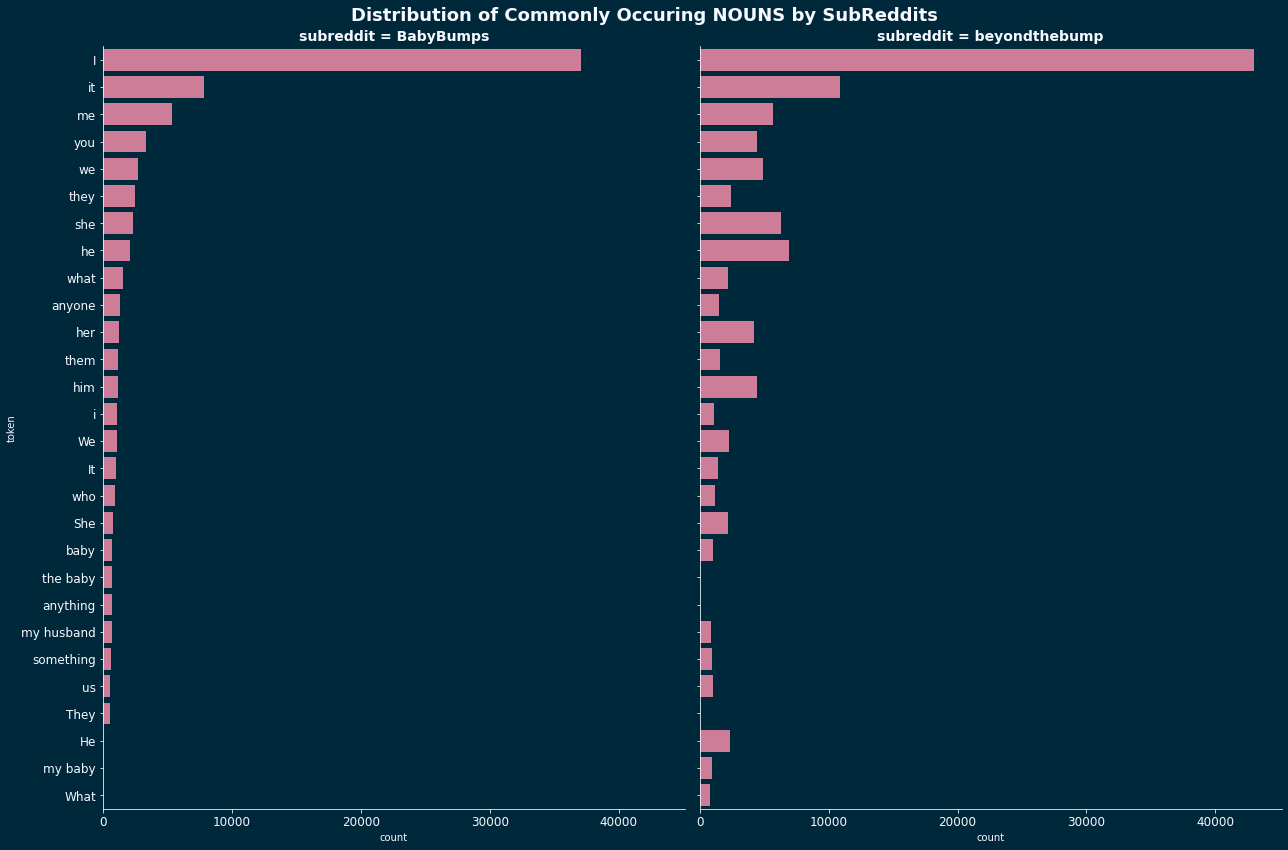

In [179]:
g = sns.catplot(data=noun_frequency, x ='count', y='token', 
            col='subreddit', ax=ax, kind='bar', orient='h',
           color='palevioletred', height=12, aspect=0.75);
g.fig.suptitle('Distribution of Commonly Occuring NOUNS by SubReddits')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()


# sns.catplot(data=noun_frequency, x ='count', y='token', 
#             col='subreddit', ax=ax, kind='bar', orient='h',
#            color='red')

### Investigating the 'flair' tagging using in subreddits. Flairs are essentially a tags that categorizes the post into various subtopics

In [181]:
df.groupby('subreddit')['link_flair_text'].value_counts(normalize=True)

subreddit      link_flair_text         
BabyBumps      Help?                       0.418822
               Rant/Vent                   0.154454
               Discussion                  0.146193
               Nursery/Gear                0.048491
               Info                        0.029813
               Happy                       0.029454
               Funny                       0.026221
               Sad                         0.024784
               Food                        0.021193
               New here                    0.019756
               Content/Trigger Warning     0.018678
               Birth info                  0.016882
               TMI                         0.015445
               Tip!                        0.014727
               Checkup                     0.006106
               Loss                        0.003951
               Birth Info                  0.001796
               IN LABOR!                   0.001796
               Symptom  

In [184]:
punctuation = r'''[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]?'''
#punctuation = r"'-"
tokenizer = RegexpTokenizer(r'\w+' + punctuation + r'\w+?|[^\s]+?')

## **EDA of Acronyms**
- Each subreddit has some predefined acronyms. These acronyms are generally understood amongst the users of subreddits and as a convention are always in uppercase

In [186]:
acronyms = ['CP', 'CW', 'DH', 'EDD', 'EP', 'FET', 'FTM', 'FTP', 'IVF', 'GTT', 'LMP', 'LO', 
            'MC', 'MMC', 'MW', 'NIPT', 'NT Scan', 'OB', 'POAS', 'PPD', 'PND', 'PPA', 'PNA', 
            'STM', 'TTM', '4TM', 'TIC', 'TW', 'US', 'AF', 'AFP', 'AS', 'BC', 'BF', 'BFN', 
            'BFP', 'BH', 'BIL', 'BM', 'BP', 'CD', 'CNM', 'DD', 'DH', 'D&C', 'DPO', 'EBF', 
            'ECV', 'EDD', 'EFF', 'FIL', 'FTM', 'FYI', 'GBS', 'GD', 'HB', 'HBAC', 'HCG', 
            'HG', 'Hormotional', 'IUD', 'IVF', 'L&D', 'Line Jumping', 'LO', 'LMP', 'LPT', 
            'MIL', 'MP', 'NSFW', 'NST', 'NT', 'OB', 'PCOS', 'PDA', 'PIT', 'PP', 'PPD', 'PRE', 
            'Prodromal', 'PSA', 'RLP', 'SCH', 'SIL', 'SO', 'SPD', 'TIL', 'TL;DR', 'TMI', 'TTC', 
            'US', 'UTI', 'VBAC']

In [187]:
def uppercase_word_count(srs):
    #re.sub(r'[a-z]', '', 
    #make a list of uppercase words in the given row
    #remove lowercase letter if part of uppercase such as MILs = MIL
    uppercase_nested_list = srs.apply(lambda x : [re.sub(r'[a-z]', '',string) for string in x.split() \
                                                if (bool(re.search(r'[A-Z]{2,}', string)) and len(string)<=15)]\
                                                    ).to_list()
    #filter out empty lists. rows where no upper case was present
    uppercase_nested_list = list(filter(lambda x: len(x) > 0, uppercase_nested_list))
    #nested to flat list
    uppercase_flat_list = [item for sublist in uppercase_nested_list for item in sublist]

    punct = string.punctuation
    translator = str.maketrans(dict.fromkeys(punct, ''))

    #removes non ascii characters (ellipsis was found MIL...) re.sub(r'[^\x00-\x7f]',r'',item.translate(translator))
    #removes punctuation item.translate(translator)
    uppercase_flat_list = [re.sub(r'[^\x00-\x7f]',r'',item.translate(translator)) for item in uppercase_flat_list]

    c = Counter(uppercase_flat_list)
    d = {k: v for k, v in c.items()}
    return d
    #uppercase_word_count_df = pd.DataFrame.from_dict(data=d, orient='index', columns=['count'])
    #return uppercase_word_count_df


In [188]:
subreddits = list(df['subreddit'].value_counts().index)

### Acronymns occuring in the TITLE of the posts

In [190]:
temp_df_list = []
for subreddit in subreddits:
    temp_df = pd.DataFrame()
    srs = df[df['subreddit'] ==  subreddit]['title']
    d = uppercase_word_count(srs)
    temp_df = pd.DataFrame.from_dict(data=d, orient='index', columns=[subreddit])
    temp_df_list.append(temp_df)

uppercase_word_count_df = pd.concat(temp_df_list, axis=1)
uppercase_word_count_df.fillna(0, inplace=True)
uppercase_word_count_df['Total'] = uppercase_word_count_df['beyondthebump'] + uppercase_word_count_df['BabyBumps']
uppercase_word_count_df.sort_values(by = 'Total', ascending=False)

,beyondthebump,BabyBumps,Total
FTM,28.0,75.0,103.0
LO,65.0,3.0,68.0
MIL,38.0,20.0,58.0
TIC,3.0,55.0,58.0
PP,44.0,12.0,56.0
...,...,...,...
CCAOA,1.0,0.0,1.0
PARENTHOOD,1.0,0.0,1.0
ABOUT,1.0,0.0,1.0
THINGS,1.0,0.0,1.0


### Acronyms occuring in the TEXT of the posts

In [191]:
temp_df_list = []
for subreddit in subreddits:
    temp_df = pd.DataFrame()
    srs = df[df['subreddit'] ==  subreddit]['selftext']
    d = uppercase_word_count(srs)
    temp_df = pd.DataFrame.from_dict(data=d, orient='index', columns=[subreddit])
    temp_df_list.append(temp_df)

uppercase_word_count_df = pd.concat(temp_df_list, axis=1)
uppercase_word_count_df.fillna(0, inplace=True)
uppercase_word_count_df['Total'] = uppercase_word_count_df['beyondthebump'] + uppercase_word_count_df['BabyBumps']
uppercase_word_count_df.sort_values(by = 'Total', ascending=False)

,beyondthebump,BabyBumps,Total
LO,852.0,62.0,914.0
OB,109.0,433.0,542.0
FTM,214.0,300.0,514.0
MIL,236.0,113.0,349.0
SO,147.0,167.0,314.0
...,...,...,...
HECK,1.0,0.0,1.0
NEW,1.0,0.0,1.0
KNOCK,1.0,0.0,1.0
SEETHING,1.0,0.0,1.0


### Acronyms occuring in both the title and text of the posts

In [192]:
temp_df_list = []
for subreddit in subreddits:
    temp_df = pd.DataFrame()
    df['titleselftext'] = df['title'] + ' ' + df['selftext']
    srs = df[df['subreddit'] ==  subreddit]['titleselftext']
    d = uppercase_word_count(srs)
    temp_df = pd.DataFrame.from_dict(data=d, orient='index', columns=[subreddit])
    temp_df_list.append(temp_df)

uppercase_word_count_df = pd.concat(temp_df_list, axis=1)
uppercase_word_count_df.fillna(0, inplace=True)
uppercase_word_count_df['Total'] = uppercase_word_count_df['beyondthebump'] + uppercase_word_count_df['BabyBumps']
# uppercase_word_count_df.sort_values(by = 'Total', ascending=False).to_csv('../predictions/uppercase_word_count_df.csv')
uppercase_word_count_df.sort_values(by = 'Total', ascending=False)

,beyondthebump,BabyBumps,Total
LO,917.0,65.0,982.0
FTM,242.0,375.0,617.0
OB,111.0,451.0,562.0
MIL,274.0,133.0,407.0
SO,160.0,178.0,338.0
...,...,...,...
HEERBV,0.0,1.0,1.0
SMOCK,1.0,0.0,1.0
TOYS,1.0,0.0,1.0
LABOUR,0.0,1.0,1.0


In [193]:
thresh = 25
uppercase_word_count_df[uppercase_word_count_df['Total']>thresh].sort_values(by = 'Total', ascending=False)

,beyondthebump,BabyBumps,Total
LO,917.0,65.0,982.0
FTM,242.0,375.0,617.0
OB,111.0,451.0,562.0
MIL,274.0,133.0,407.0
SO,160.0,178.0,338.0
...,...,...,...
ANY,16.0,10.0,26.0
TO,15.0,11.0,26.0
NEVER,14.0,12.0,26.0
CIO,26.0,0.0,26.0


In [194]:
accepted_acronyms = list(set(acronyms).intersection(set(uppercase_word_count_df.index)))

In [195]:
uppercase_word_count_df = uppercase_word_count_df.loc[(accepted_acronyms)]

In [196]:
thresh = 25
uppercase_word_count_df = uppercase_word_count_df[uppercase_word_count_df['Total']>thresh].sort_values(by = 'Total', ascending=False)
uppercase_word_count_df

,beyondthebump,BabyBumps,Total
LO,917.0,65.0,982.0
FTM,242.0,375.0,617.0
OB,111.0,451.0,562.0
MIL,274.0,133.0,407.0
SO,160.0,178.0,338.0
PP,169.0,34.0,203.0
US,67.0,91.0,158.0
PPD,144.0,11.0,155.0
SIL,39.0,73.0,112.0
EBF,88.0,3.0,91.0


In [197]:
uppercase_word_count_df.shape

(35, 3)

In [204]:
def drawPieMarker(xs, ys, ratios, sizes, colors):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 100)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 100)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter([xs], [ys], **marker)

In [205]:
#function calculates xposition and yposition on a concentric circle by splitting it into predefined equal slices
def calc_xpos_ypos(n_splits):
    if n_splits == 0:
        xpos = [0]
        ypos = [0]
        return xpos, ypos
    n_splits = 4*n_splits
    angle_delta = 360/n_splits
    xpos = []
    ypos = []
    for i in range(n_splits):
        angle = i * angle_delta
        rad = np.radians(angle)
        xpos.append(round(np.cos(rad),2))
        ypos.append(round(np.sin(rad),2))
    return xpos, ypos
    print(list(zip(xpos, ypos)))

<ipython-input-206-ce13cc05db1b>:59: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


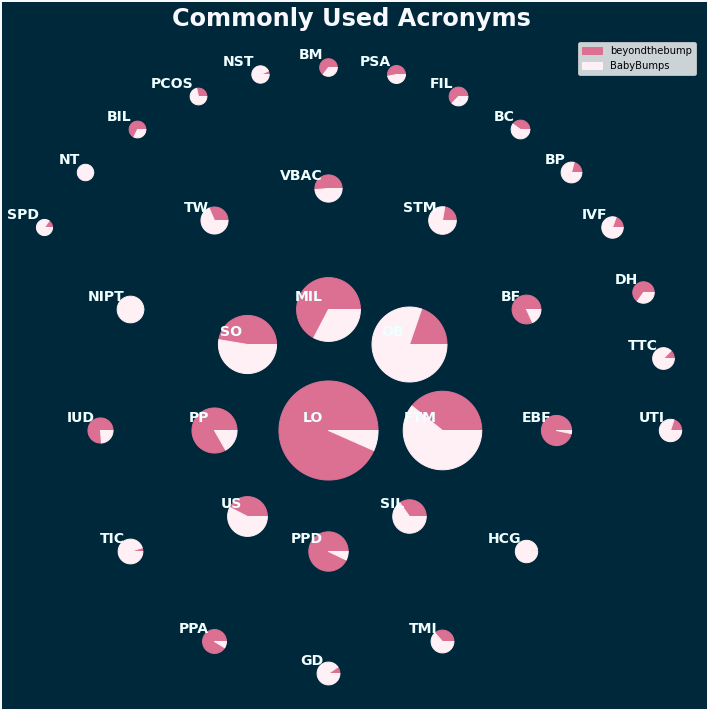

In [206]:
fig, ax = plt.subplots(figsize=(10,10))
colors = ['palevioletred', 'lavenderblush']
splits_by_circle_layer =[0, 2, 3, 8, 5, 6, 7, 8, 9, 10, 11]
count = 0
splits_idx = 0
circle_layer = 0
xpos = []
ypos = []
xs, ys = calc_xpos_ypos(splits_by_circle_layer[splits_idx])
for index, row in uppercase_word_count_df.iterrows():
    if count == len(xs):
        splits_idx += 1
        xs, ys = calc_xpos_ypos(splits_by_circle_layer[splits_idx])
        count = 0
        circle_layer += 1
    ratio1 = row.values[0]/row.values[-1]
    ratio2 = row.values[1]/row.values[-1]
    drawPieMarker(xs=xs[count]*circle_layer*.5,
              ys=ys[count]*circle_layer*.5,
              ratios=[ratio1, ratio2],
              sizes=row.values[-1]*10,
              colors=colors)
    xpos.append(xs[count]*circle_layer*.5)
    ypos.append(ys[count]*circle_layer*.5)
    count += 1

    

#     https://stackoverflow.com/questions/5147112/how-to-put-individual-tags-for-a-matplotlib-scatter-plot
for label, x, y in zip(uppercase_word_count_df.index, xpos, ypos):
    plt.annotate(
    label,
    xy=(x, y), 
    xytext=(-5, 5),
    textcoords='offset points', ha='right', va='bottom',
        fontweight='extra bold', fontsize=14, color='azure'
#     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#     arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
legend_dict = { 'beyondthebump' : colors[0], 'BabyBumps' : colors[1]}

patchList = []
for key in legend_dict:
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)

plt.legend(handles=patchList)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.axis('off')
fig.patch.set_edgecolor('ghostwhite')
fig.patch.set_linewidth('3')

ax.set_facecolor('#00283b')
fig.set_facecolor('#00283b')
fig.suptitle('Commonly Used Acronyms', fontsize=24, fontweight = 'extra bold', 
             fontfamily = 'Cambria', color = 'ghostwhite')
plt.tight_layout(True)

## **EDA as Bag-of-Words Approach**

In [207]:
def word_split(text):
    #print (text)
    # split into words by white space
    words = text.split()
    # remove punctuation from each word
    #table = str.maketrans('', '', '''!"#$%&'()*+,.:;<=>?@[\]^_`{|}~''')
    table = str.maketrans('', '', string.punctuation)

    stripped = [w.lower().translate(table) for w in words]
    return list(filter(None, stripped))  # there were empty strings in the list where the text contained space followed \
                                        # by a period followed by a space '_._'

In [208]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_split(doc)]

In [209]:
class PorterStemming:
    def __init__(self):
        self.pst = PorterStemmer()
    def __call__(self, doc):
        return [self.pst.stem(t) for t in word_split(doc)]

In [211]:
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words


In [212]:
# Instantiate PorterStemmer.
p_stemmer = PorterStemmer()

In [213]:
table = str.maketrans('', '', string.punctuation)
p_stemmer_stopwords_spacy = [w.lower().translate(table) for w in sw_spacy]
p_stemmer_stopwords_spacy = [p_stemmer.stem(i) for i in p_stemmer_stopwords_spacy]

In [214]:
table = str.maketrans('', '', string.punctuation)
p_stemmer_stopwords = [w.lower().translate(table) for w in stopwords.words("english")]
p_stemmer_stopwords = [p_stemmer.stem(i) for i in p_stemmer_stopwords]


In [215]:
cvec = CountVectorizer( stop_words = p_stemmer_stopwords_spacy,tokenizer=PorterStemming())
#cvec = CountVectorizer( stop_words = p_stemmer_stopwords)

In [216]:
X = df['title'] + ' ' + df['selftext']
y = df['subreddit'].map({'beyondthebump':0, 'BabyBumps':1})

In [217]:
Xcv = cvec.fit_transform(X)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'becau', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [218]:
Xcv_df = pd.DataFrame(data=Xcv.todense(), columns=cvec.get_feature_names())
Xcv_df.columns

Index(['0', '00', '000', '00001', '001', '0024', '01', '010', '0100', '0130',
       ...
       'zoo', 'zoom', 'zoomi', 'zs', 'zucchini', 'zumba', 'zygot', 'zyrtec',
       'zz', 'zzz'],
      dtype='object', length=21270)

In [219]:
beyondthebump_words_index = y[y==0].index

In [220]:
beyondthebump_high_freq_words = Xcv_df.loc[beyondthebump_words_index].sum().sort_values(ascending=False).head(50)
beyondthebump_high_freq_words.name = 'beyondthebump'

In [221]:
BabyBumps_words_index = y[y==1].index

In [222]:
BabyBumps_high_freq_words = Xcv_df.loc[BabyBumps_words_index].sum().sort_values(ascending=False).head(50)
BabyBumps_high_freq_words.name = 'BabyBumps'

In [223]:
high_freq_words = pd.concat([beyondthebump_high_freq_words, BabyBumps_high_freq_words], join='outer', axis=1)

In [224]:
high_freq_words.fillna(0, inplace=True)

In [225]:
high_freq_words['Total'] = high_freq_words['beyondthebump'] + high_freq_words['BabyBumps']
high_freq_words = high_freq_words.sort_values(by='Total', ascending=False)
high_freq_words

,beyondthebump,BabyBumps,Total
im,7462.0,7371.0,14833.0
babi,7949.0,4736.0,12685.0
like,4758.0,3434.0,8192.0
week,3612.0,4214.0,7826.0
feel,3853.0,3437.0,7290.0
...,...,...,...
famili,0.0,786.0,786.0
experi,0.0,785.0,785.0
labor,0.0,775.0,775.0
hospit,0.0,739.0,739.0


<ipython-input-226-1ae0f14de586>:59: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


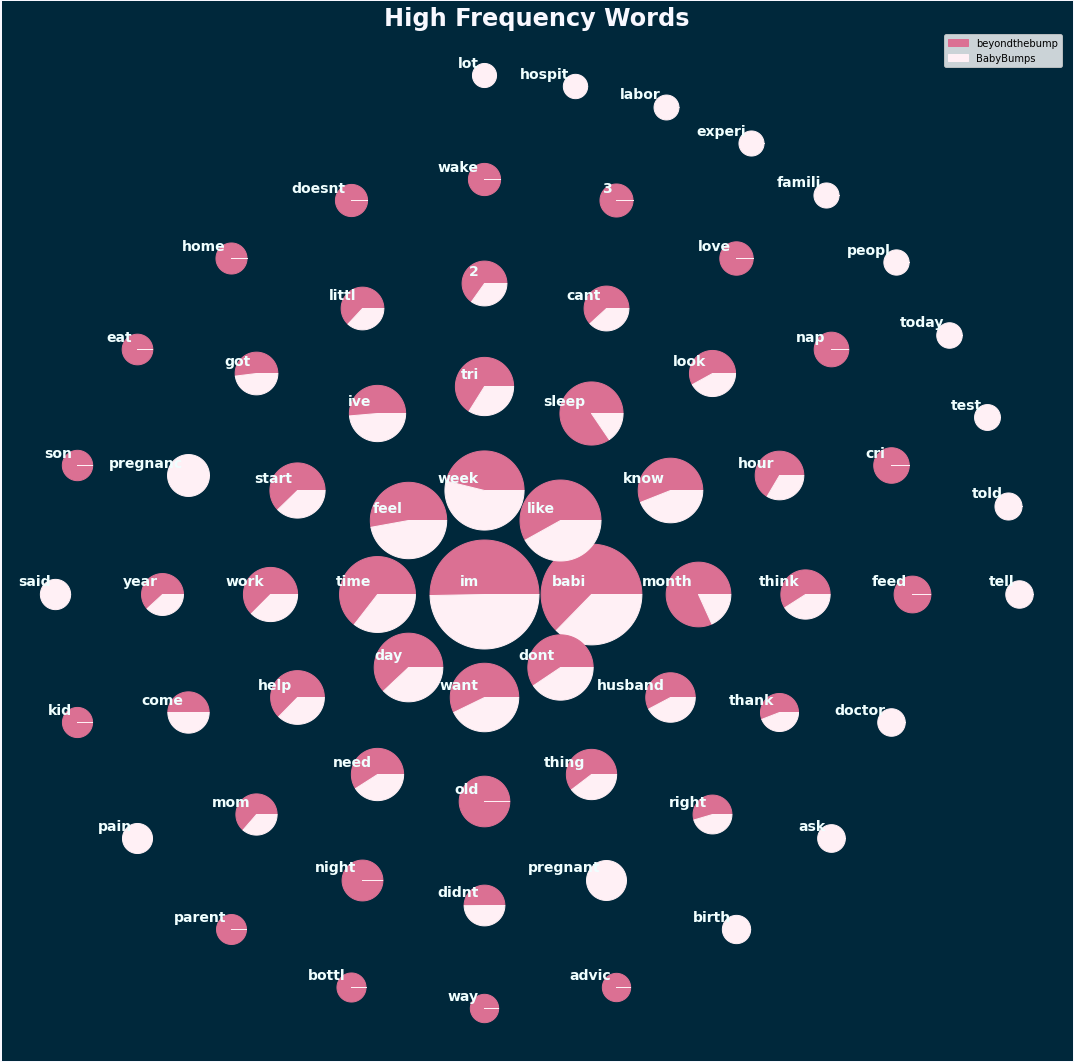

In [226]:
fig, ax = plt.subplots(figsize=(15,15))
colors = ['palevioletred', 'lavenderblush']
splits_by_circle_layer =[0, 2, 3, 4, 5, 9, 7, 8, 9, 10, 11]
count = 0
splits_idx = 0
circle_layer = 0
xpos = []
ypos = []
xs, ys = calc_xpos_ypos(splits_by_circle_layer[splits_idx])
for index, row in high_freq_words.iterrows():
    if count == len(xs):
        splits_idx += 1
        xs, ys = calc_xpos_ypos(splits_by_circle_layer[splits_idx])
        count = 0
        circle_layer += 1
    ratio1 = row.values[0]/row.values[-1]
    ratio2 = row.values[1]/row.values[-1]
    drawPieMarker(xs=xs[count]*circle_layer*2,
              ys=ys[count]*circle_layer*2,
              ratios=[ratio1, ratio2],
              sizes=row.values[-1]*0.8,
              colors=colors)
    xpos.append(xs[count]*circle_layer*2)
    ypos.append(ys[count]*circle_layer*2)
    count += 1

    

#     https://stackoverflow.com/questions/5147112/how-to-put-individual-tags-for-a-matplotlib-scatter-plot
for label, x, y in zip(high_freq_words.index, xpos, ypos):
    plt.annotate(
    label,
    xy=(x, y), 
    xytext=(-5, 5),
    textcoords='offset points', ha='right', va='bottom',
        fontweight='extra bold', fontsize=14, color='azure'
#     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#     arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
legend_dict = { 'beyondthebump' : colors[0], 'BabyBumps' : colors[1]}

patchList = []
for key in legend_dict:
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)

plt.legend(handles=patchList)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.axis('off')
fig.patch.set_edgecolor('ghostwhite')
fig.patch.set_linewidth('3')

ax.set_facecolor('#00283b')
fig.set_facecolor('#00283b')
fig.suptitle('High Frequency Words', fontsize=24, fontweight = 'extra bold', 
             fontfamily = 'Cambria', color = 'ghostwhite')
plt.tight_layout(True)

## Sentiment Analysis

In [6]:
#instantiate SIA

sia = SentimentIntensityAnalyzer()

In [7]:
corpus = list(df['title'] + ' ' + df['selftext'])

In [8]:
#create dataframe that contains text and the polarity scores for each tweet

sentiment = []    

for title_selftext in corpus:
    scores = sia.polarity_scores(title_selftext)
    scores['title_selftext'] = title_selftext
    sentiment.append(scores)

sent_df = pd.DataFrame(sentiment)
sent_df.head()

,neg,neu,pos,compound,title_selftext
0,0.156,0.708,0.135,-0.6018,Why are wearable baby monitors like the Owlet ...
1,0.018,0.720,0.263,0.9966,Can anyone point me in the right direction? I ...
2,0.058,0.895,0.047,-0.2240,RSV in 13 Month Old My 13 month old has been b...
3,0.028,0.885,0.087,0.9243,Introducing peanuts and spit up - 6.5 months B...
4,0.043,0.835,0.122,0.9053,If your hired babysitter flaked on you last mi...


In [9]:
sent_df['subreddit'] = df['subreddit']

In [10]:
sent_df['doc_id'] = range(len(df))

In [11]:
sent_df

,neg,neu,pos,compound,title_selftext,subreddit,doc_id
0,0.156,0.708,0.135,-0.6018,Why are wearable baby monitors like the Owlet ...,beyondthebump,0
1,0.018,0.720,0.263,0.9966,Can anyone point me in the right direction? I ...,beyondthebump,1
2,0.058,0.895,0.047,-0.2240,RSV in 13 Month Old My 13 month old has been b...,beyondthebump,2
3,0.028,0.885,0.087,0.9243,Introducing peanuts and spit up - 6.5 months B...,beyondthebump,3
4,0.043,0.835,0.122,0.9053,If your hired babysitter flaked on you last mi...,beyondthebump,4
...,...,...,...,...,...,...,...
10598,0.126,0.771,0.103,-0.5621,11wks and boobs are on fire! I'm 29 and on my ...,BabyBumps,10598
10599,0.025,0.878,0.097,0.8549,Physically demanding outdoor job? My husband (...,BabyBumps,10599
10600,0.012,0.858,0.130,0.9559,MTHFR advice needed Hi there! \n\nI was wonder...,BabyBumps,10600
10601,0.062,0.727,0.211,0.9274,Positive Induction Stories? Almost everyone I ...,BabyBumps,10601


In [12]:
sent_df_hist = sent_df.groupby(['subreddit', 'doc_id']).mean()['compound']

In [13]:
sent_df_hist.name = 'compound'

In [14]:
sent_df_hist = sent_df_hist.reset_index()

In [15]:
sent_df_hist

,subreddit,doc_id,compound
0,BabyBumps,6215,-0.5535
1,BabyBumps,6216,-0.9519
2,BabyBumps,6217,0.5321
3,BabyBumps,6218,0.3182
4,BabyBumps,6219,0.5994
...,...,...,...
10598,beyondthebump,6210,0.6701
10599,beyondthebump,6211,0.8307
10600,beyondthebump,6212,-0.9377
10601,beyondthebump,6213,-0.9385


findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


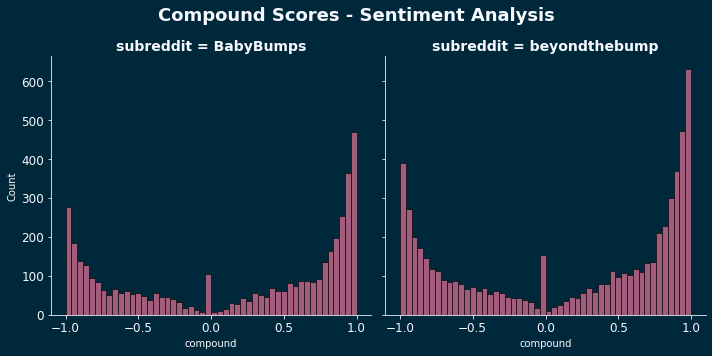

In [16]:
g = sns.displot(data=sent_df_hist, x ='compound', col='subreddit', log_scale = False, 
                color='palevioletred', height = 5, bins=50)
g.fig.suptitle('Compound Scores - Sentiment Analysis')
format_fig(fig = g, flag = 'NoFormatting', grid = 'FacetGrid')
plt.tight_layout()

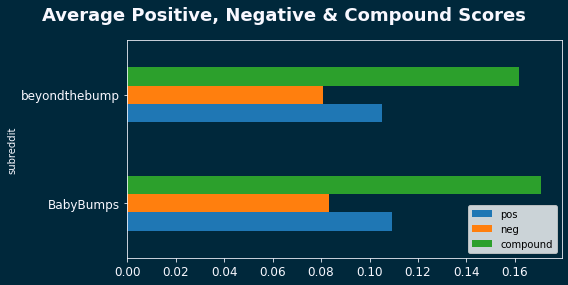

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
sent_df.groupby('subreddit').mean()[['pos', 'neg', 'compound']].plot(kind='barh', ax=ax)
fig.suptitle('Average Positive, Negative & Compound Scores');
format_fig(fig = fig, flag = 'NoFormatting', grid = 'NotFacetGrid')
plt.tight_layout()
# 1 is real disaster and 0 is fake disaster